# Structural Analysis of Protein Ensembles

This notebook does the following:
- Creates a protein structural ensemble from the PDB structures prepared in [this notebook](../../1_Download_and_prepare_protein_ensembles/4_Prepare_proteins_using_pdb4amber.ipynb). The file is saved into `.dcd` and `.pdb` format files. 
    - Structures are aligned using the $C \alpha$ atoms of the residues comprising the protein's pocket.
- The `.pdb` file is used as input for `POVME` to compute the volume and the shape of the protein's pocket.
- Pair-wise RMSD is computed among all protein conformations.
- Classical Multidimensional Scaling Analysis (cMDS) is performed using the RMSD matrix as input.

In [1]:
import pandas as pd
import numpy as np
import pytraj as pyt
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='ticks', font_scale = 1.2)

## Protein information dataframe

In [2]:
df_prot_file = '../1_Download_and_prepare_protein_ensembles/TABLA_MTDATA_CDK2_402_crys.json'
df_prot = pd.read_json(df_prot_file)
df_prot.head()

,PDB_ID,Title,Date,Entities,ChainID,Resolution,Identity,Coverage,NumGaps,GapLen,GapPos,NumLigs,NameLigs
0,1aq1,human cyclin dependent kinase 2 complexed with...,1997-11-12,1,A,2.00,298,92.953020,2,"[9, 14]","[[36, 44], [149, 162]]",1,[STU]
1,1b38,human cyclin-dependent kinase 2,1998-12-23,1,A,2.00,298,97.315436,1,[9],"[[36, 44]]",3,"[ACE, ATP, MG]"
2,1b39,human cyclin-dependent kinase 2 phosphorylated...,1998-12-23,1,A,2.10,298,97.315436,1,[9],"[[36, 44]]",3,"[ACE, ATP, MG]"
3,1buh,crystal structure of the human cdk2 kinase com...,1998-09-09,2,A,2.60,298,96.308725,2,"[8, 5]","[[40, 47], [295, 299]]",0,[]
4,1ckp,human cyclin dependent kinase 2 complexed with...,1999-01-13,1,A,2.05,298,93.624161,2,"[9, 12]","[[36, 44], [153, 164]]",2,"[EDO, PVB]"


## Protein structural ensemble

In [3]:
%run ../../helper_modules/protein_subsequences.py

In [4]:
# Create a trajectory file using the protein ensemble
path_to_pdb_files = '../1_Download_and_prepare_protein_ensembles/pdb_structures/pdb_prepared/*'

# Load all protein structures to a single trajectory
crys_traj = pyt.io.iterload(filename = path_to_pdb_files)

In [5]:
print(f' Number of conformations: {crys_traj.n_frames}\n',
      f'Number of atoms per frame: {crys_traj.n_atoms}.')

 Number of conformations: 402
 Number of atoms per frame: 4848.


### Save protein Ensemble as PDB trajectory
- **Alingment using Pisani (2016) subsequence** comprising secondary structure residues from the N-terminal region of CDK2.

In [8]:
pisani_subseq = get_pisani_residues(sep=',')
sec_str_mask = f':{pisani_subseq}&(@CA)'
pisani_alg = pyt.align(crys_traj, mask = sec_str_mask)
# Save the traj (not included in the repo): This traj was used to compute POVME, check folder ./POVME_results
# pyt.write_traj('./PDB_402_cdk2_PISANI_ALL.pdb', pisani_alg)

- **Alingment using Pocket subsequence**: PDB format as was used to compute Volumne using POVME3, check folder `./POVME_results`

In [9]:
pocket_subseq = get_pocket_residues(sep = ',')
pkt_str_mask = f':{pocket_subseq}&(@CA)'
pocket_alg = pyt.align(crys_traj, mask = pkt_str_mask)
# Save the traj: This traj was used to compute POVME, check folder ./POVME_results
# pyt.write_traj('./PDB_402_cdk2_POCKET_ALL.pdb', pocket_alg)

## Pocket Volume information
- Add Pocket Volume information computed by POVME3 to the protein dataframe

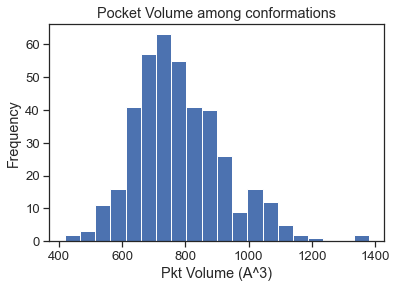

In [10]:
pocket_vol_file = './POVME3_results/Pocket_alignment/res_volumes.tabbed.txt'
# Keep only the Volume column from the POVME3 results
df = pd.read_csv(pocket_vol_file, sep='\t', 
                 header=None, names=['conf_num', 'volume'])[['volume']]
# Add the volumen information to the main dataframe
df_prot['pocket_volume'] = df.volume

ax = df_prot.pocket_volume.plot.hist(bins = 20)
ax.set(title = 'Pocket Volume among conformations', xlabel = 'Pkt Volume (A^3)')
plt.show()

## Classical Multidimensional Scaling

In [11]:
%run ../../helper_modules/MDS.py

#### cMDS: Using RMSD as distance metric


In [12]:
# Compute the distance matrices
pair_rmsd_sec = pyt.pairwise_rmsd(traj = crys_traj,
                                  mask = sec_str_mask, 
                                  metric ='rms')

pair_rmsd_pkt = pyt.pairwise_rmsd(traj = crys_traj,
                                  mask = pkt_str_mask, 
                                  metric ='rms')

In [13]:
# Compute cMDS
mds_sec = cMDS(pair_rmsd_sec)[0]
mds_pkt = cMDS(pair_rmsd_pkt)[0]

#### Visualize the projections

In [12]:
def plot_subspace(x, y, title = '', **kwargs):
    '''A simple scatterplot function'''
    fig, ax = plt.subplots(figsize = (6, 6))
    sns.scatterplot(x = x, y = y, alpha = 0.6,
                    linewidth = 0, color = '#02A298',
                    **kwargs
                   )
    ax.set_title(title)
    ax.set(xlabel = 'Dim. 1', ylabel = 'Dim. 2')
    ax.axvline(0, ls = ':', color = 'gray')
    ax.axhline(0, ls = ':', color = 'gray')
    ax.grid()
    plt.show()

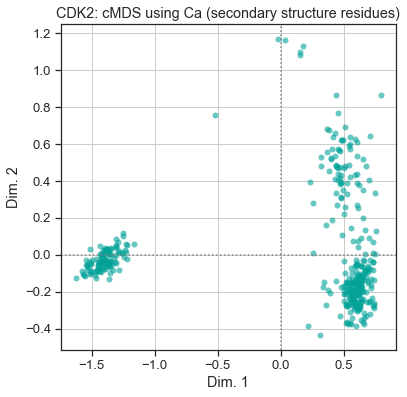

In [13]:
# Visualize the projection
x, y = mds_sec[:2]
plot_subspace(x, y, 
    title = 'CDK2: cMDS using Ca (secondary structure residues)')

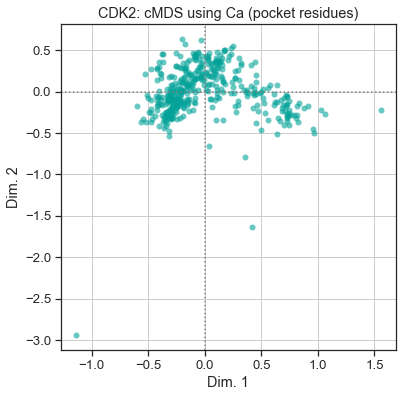

In [14]:
# Visualize the projection
x, y = mds_pkt[:2]
plot_subspace(x, y, 
    title = 'CDK2: cMDS using Ca (pocket residues)')

#### cMDS: Using pocket shape similarity

In [15]:
# Load POVME3 results
path_povme_results = './POVME3_results/Pocket_alignment/'
vol_tan_mtx = pd.read_csv(f'{path_povme_results}/POVME_Tanimoto_matrix.csv', header=None)

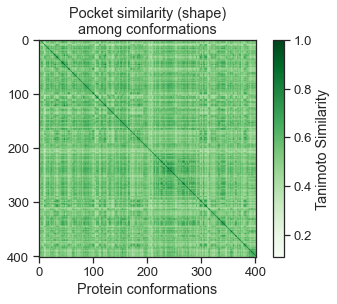

In [16]:
# The following figure shows the 
# Tanimoto Similarity among pockets saphes
fig, ax = plt.subplots()
plt.imshow(vol_tan_mtx, cmap = 'Greens')
ax.set(xlabel = 'Protein conformations',
       title  = "Pocket similarity (shape)\n" + \
                "among conformations"
      )
plt.colorbar(label = 'Tanimoto Similarity')
plt.show()

In [17]:
# cMDS using Tanimoto
# Compute a dissimilarity matrix
dism_mtx = 1 - vol_tan_mtx
mds_vol_pkt = cMDS(dism_mtx)[0]

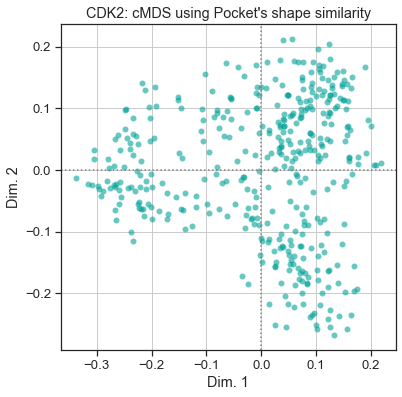

In [18]:
# Visualize the projection
x, y = mds_vol_pkt[:2]
plot_subspace(x, y, 
    title = "CDK2: cMDS using Pocket's shape similarity")

## CDK2: Interactive projection
Finally, we will include a bokeh plot showing an interactive projection

In [19]:
from bokeh.plotting import show, figure
from bokeh.io import output_notebook
from bokeh.models import ResetTool, PanTool, WheelZoomTool, \
ColumnDataSource, Span, HoverTool, LabelSet, Range1d,  OpenURL, TapTool
from bokeh.transform import factor_cmap
output_notebook()

Loading BokehJS ...

In [20]:
path_to_json_file = './TABLA_MTDATA_CDK2_402_crys_LIGS_INFO_LABELS_AUC_docking.json'
df_prot_labels = pd.read_json(path_to_json_file)

mds = mds_sec

In [21]:
# tools reference
HOVER = HoverTool(names=["Crystals"])
TOOLTIPS = [
    ("index", "$index"),
    ("PDB ID", "@pdb_id"),
    ("conf", "@conf_label")]
TOOLS = ['pan', 'wheel_zoom', HOVER, ResetTool()]

df_prot = df_prot_labels

f = figure(plot_width = 900, plot_height = 700,
           title = 'cMDS: Trajectory projection',
           match_aspect=True, active_scroll='wheel_zoom',
           tooltips = TOOLTIPS, tools = TOOLS)


# Styling del plot
f.title.text_font_size = '2em'

# Axis
f.axis.axis_line_width = 3.3
f.axis.major_label_text_font_size = '1.1em'
f.axis.major_label_text_font_style = 'bold'

# Labels
f.axis.axis_label_text_font_size = '1.4em'
f.xaxis.axis_label = 'First Dimension'
f.yaxis.axis_label = 'Second Dimension'

# cMDS subspace
x, y = mds[:2]
ref_pisani = ColumnDataSource({
    'x': x, 'y': y})

# Datasource
conformation_labels = df_prot_labels.Labels_conf
conf_labels = conformation_labels.unique()
source_ref = ColumnDataSource(data = dict(
    x = x,
    y = y,
    pdb_id = df_prot_labels.index.to_series().apply(lambda x: x.upper()),
    conf_label = df_prot_labels.Labels_conf
))

# Vertical line
vline = Span(location=0, dimension='height', 
             line_color='grey', line_width=2, line_dash='dashed')
# Horizontal line
hline = Span(location=0, dimension='width', 
             line_color='grey', line_width=2, line_dash='dashed')
f.renderers.extend([vline, hline])

CONFS = df_prot.Labels_conf.unique()
colors_list = [ '#036193', '#23B537', '#E93523', 'gray',   '#FEA50A','#23E9BC']
confs_cmap = factor_cmap('conf_label', colors_list, CONFS)

# Scattter plot
f.scatter('x', 'y', source = source_ref, name = 'Crystals',
          size = 10, alpha = 0.7, color = confs_cmap, 
          line_color = '#111111',
          legend_label = 'CDK2 Conformations', muted_alpha = 0.1)

f.toolbar_location = 'above'
f.toolbar.logo = None

f.legend.click_policy = "mute"
f.legend.location = 'top_left'
url = 'https://www.rcsb.org/structure/@pdb_id'
taptool = f.select(type = TapTool)
taptool.callback = OpenURL(url = url)
show(f)

## Save the projections

In [22]:
df_dims = pd.DataFrame([mds_sec[0], mds_sec[1],
                        mds_pkt[0], mds_pkt[1],
                        mds_vol_pkt[0], mds_vol_pkt[1]]).T

# Set names
colnames = ['mds_sec_x', 'mds_sec_y',
            'mds_pkt_x', 'mds_pkt_y',
            'mds_vol_pkt_x', 'mds_vol_pkt_y',
           ]

# Set the names
df_dims.columns = colnames
# Set index
df_dims.index = df_prot.index
# Save to file
df_dims.to_pickle('./df_PROTEINS_DIMS_reduced_TABLE.obj')

Fnished!